In [119]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

from basic_artificial_market import ArtificialMarket

In [220]:
import numpy as np
import matplotlib.pyplot as plt
import math

class ArtificialMarket():
    def __init__(self, num_player=1000, ganma=1000, sigma=0.06, P_sigma=30):
        self.num_player = num_player
        self.random_state = np.random.RandomState()
        self.sigma = sigma
        self.P_sigma = P_sigma
    
    def weight(self, w_1_max=1, w_2_max=100, w_3_max=1):
        num_player = self.num_player
        weight_1 = np.zeros(num_player)
        weight_2 = np.zeros(num_player)
        weight_3 = np.zeros(num_player)
        random_state = self.random_state
        for i in range(num_player):
            weight_1[i] = random_state.uniform()*w_1_max
            weight_2[i] = random_state.uniform()*w_2_max
            weight_3[i] = random_state.uniform()*w_3_max
        weight = [weight_1, weight_2, weight_3]
        return weight
    
    def ganma(self, ganma_max=10, num_player=None):
        random_state = self.random_state
        if num_player is None:
            num_player = self.num_player
        ganma = np.array([])
        for i in range(num_player):
            ganma = np.append(ganma, int(random_state.uniform(ganma_max)))
        return ganma
    
    def P_t(self, past_data, delta_l, delta_t):
        if np.sum(delta_t) <= delta_l:
            P_t = past_data[-1]
        else: 
            d = 0
            j = 0
            while d <= delta_l:
                d += delta_t[-j]
                j += 1
            P_t = past_data[-j]
        return P_t
    
    def r_t_h(self, past_data, P_t, ganma):
        if len(past_data) < ganma:
            r_t_h = np.log10(P_t/past_data[0])
        else:
            past_data_ganma = past_data[-ganma]
            r_t_h = np.log10(P_t/past_data_ganma)
        return r_t_h
        
    def one_market_model(self, delta_l, w, ganma, fdmtl=10000.0, b_limit=None, s_limit=None, t=0, delta_t=None, past_data=None, market_order=0, delta=1):
        num_player = self.num_player
        sigma = self.sigma
        P_sigma = self.P_sigma
        P_f = fdmtl
        
        if past_data is None:
            past_data = np.array([P_f])
        if b_limit is None:
            b_limit = np.array([])
        if s_limit is None:
            s_limit = np.array([])
        
        if delta_t is None:
            delta_t = np.array([])
            
        w_1 = w[0]
        w_2 = w[1]
        w_3 = w[2]
        r_t_e = np.zeros(num_player)
                
        for i in range(num_player):
            P_t_1 = past_data[-1]
            #P_t_1 = self.P_t(past_data, delta_l, delta_t)
            
            r_t_h = self.r_t_h(past_data, P_t_1, ganma[i])
            
            e_t = np.random.normal(0, sigma)
            
            r_t_e[i] = (w_1[i]*np.log10(P_f/P_t_1) + w_2[i]*r_t_h + w_3[i]*e_t)/(w_1[i] + w_2[i] + w_3[i])
            P_e = P_t_1*math.exp(r_t_e[i])
            
            P_o = np.random.normal(P_e, P_sigma)
            
            #print w_1[i]*np.log10(P_f/P_t_1), w_2[i]*r_t_h, r_t_e[i]
            
            if P_e > P_o:
                P_o = round(P_o, 1)
                if len(s_limit) > 10 and np.min(s_limit) < P_o:
                    market_order += 1
                    P_t = np.min(s_limit)
                    s_limit = np.delete(s_limit, np.argmin(s_limit))
                else:
                    b_limit = np.append(b_limit, P_o)
                    P_t = P_t_1
            else:
                P_o = round(P_o, 1)+0.1
                if len(b_limit) > 10 and np.max(b_limit) > P_o:
                    market_order += 1
                    P_t = np.max(b_limit)
                    b_limit = np.delete(b_limit, np.argmax(b_limit))
                else:
                    s_limit = np.append(s_limit, P_o)
                    P_t = P_t_1
            past_data = np.append(past_data, P_t)
            delta_t = np.append(delta_t, np.random.exponential(delta))
            t += delta_t[-1]
        return t, delta_t, past_data, b_limit, s_limit, market_order
        
    def one_market_simulation(self, delta_l, o_max=10000, fdmtl=10000):
        o = 0
        w = self.weight()
        ganma = self.ganma()
        t, delta_t, past_data, b_limit, s_limit, market_order = self.one_market_model(delta_l, w, ganma, fdmtl)
        while o < o_max:
            t, delta_t, past_data, b_limit, s_limit, market_order = self.one_market_model(delta_l, w, ganma, fdmtl, b_limit, s_limit, t, delta_t, past_data, market_order)
            o += 1
        return past_data, t, market_order
    
    def rad(self, past_data, fdmtl=10000.0):
        p = 0
        for i in range(len(past_data)):
            p += math.fabs(float(past_data[i]) - fdmtl)/fdmtl
        m = 1.0/float(len(past_data))*p
        return m
    
    def agreed_rate(self, past_data, market_order):
        print market_order
        agreed_rate = float(market_order)/float(len(past_data))
        return agreed_rate

0.0002801908917371384

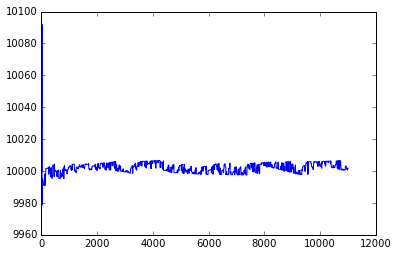

In [232]:
AM = ArtificialMarket()
k, t, market_order= AM.one_market_simulation(0, 10)
plt.plot(k)
AM.rad(k)

In [233]:
AM.agreed_rate(k, market_order)

938


0.0852649759112808

In [205]:
k[-100:]

array([ 10007.5,  10007.5,  10007.5,  10007.5,  10007.5,  10007.5,
        10007.5,  10007.6,  10007.7,  10007.7,  10007.7,  10007.7,
        10007.7,  10007.7,  10007.7,  10002.6,  10002.6,  10002.6,
         9986.1,   9981.8,   9980.4,   9980.4,   9980.4,   9980.4,
         9980.4,   9980.4,   9980.4,   9980.4,   9980.4,   9980.4,
         9980.4,   9980.4,   9980.4,   9980.4,   9979.7,   9979.7,
         9979.7,   9979.7,   9979.7,   9975.3,   9975.3,   9975.3,
         9974.8,   9974.8,   9974.8,   9974.8,   9973.5,   9973.5,
         9973.5,   9973.5,   9973.5,   9973.5,   9973.1,   9973.1,
         9973.1,   9973.1,   9973.1,   9973.1,   9972.8,   9972.8,
         9972.8,   9972.8,   9979.8,   9979.8,   9979.8,   9979.9,
         9994. ,   9994. ,   9974.3,   9974.3,   9972.3,   9972.3,
         9972.3,   9972.3,   9972.3,   9971.2,   9971.2,   9971.2,
         9971.2,   9971.2,   9971.2,   9977.9,   9977.9,   9977.9,
         9977.9,   9977.9,   9984.8,   9984.8,   9984.8,   997

[  9929.35884192   9930.87953013   9967.12446328   9958.50311947
   9925.02591151   9955.25973876   9859.97561989   9971.19247792
   9856.5748648    9858.38623857   9941.9959441    9974.64065106
   9603.87685759   9949.45632776   9896.90878477   9964.57888453
   9966.04145634   9939.35075343   9908.33779868   9976.16167657
   9972.93139725   9954.47319069   9894.62786427   9960.53041333
   9889.4690011    9919.28027802   9935.59200216   9869.60099255
   9657.66030342   9927.3485805    9853.68020584   9846.62891555
   9887.3573327    9965.88684522   9966.81439917   9658.22717816
   9871.69394511   9930.86480946   9928.35718587   9943.23048688
   9923.43449502   9955.82887509   9945.29654282   9964.43560748
   9951.19380712   9693.02595979   9972.58159332   9930.87578044
   9905.57629714   9908.87077576   9978.15078842   9909.77742927
   9829.78426505   9944.98572956   9970.78828919   9966.62252228
   9941.94758644   9970.68702484   9919.91224116   9718.96209267
   9938.80507757   9843.1

0.00775557

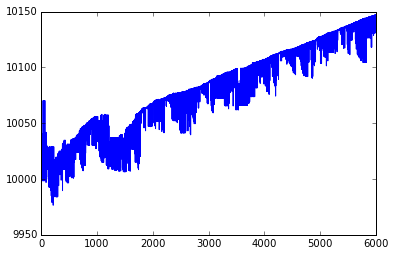

In [13]:
AM = ArtificialMarket()
k, t= AM.one_market_simulation(10, 5)
plt.plot(k)
round(AM.rad(k), 8)

In [218]:
j = np.where(k == min(k))
j

(array([14, 15, 16, 17, 18, 19, 20]),)

In [221]:
k[20:1000]

array([ 9833.27207567,  9845.8749886 ,  9845.8749886 ,  9845.8749886 ,
        9845.8749886 ,  9845.8749886 ,  9845.8749886 ,  9845.8749886 ,
        9845.8749886 ,  9845.8749886 ,  9845.8749886 ,  9853.41285104,
        9853.41285104,  9853.41285104,  9867.44270662,  9853.41285104,
        9867.44270662,  9853.41285104,  9853.41285104,  9853.41285104,
        9853.41285104,  9853.41285104,  9853.41285104,  9853.41285104,
        9853.41285104,  9853.41285104,  9867.44270662,  9867.44270662,
        9867.44270662,  9867.44270662,  9853.41285104,  9853.41285104,
        9853.41285104,  9853.41285104,  9867.44270662,  9867.44270662,
        9867.44270662,  9867.44270662,  9867.44270662,  9867.44270662,
        9867.44270662,  9867.44270662,  9853.41285104,  9853.41285104,
        9853.41285104,  9853.41285104,  9853.41285104,  9855.91445161,
        9855.91445161,  9855.91445161,  9855.91445161,  9855.91445161,
        9853.41285104,  9855.91445161,  9855.91445161,  9855.91445161,
      

In [311]:
for i in range:
    np.random.exponential(1)

1.4960887944860213

In [464]:
k = [1, 3, 4, 5, 1, 5]
k = np.delete(k, np.max(k))
k

array([1, 3, 4, 5, 1])

In [ ]:
if past_data[-1] > past_data[-2] + 100:
                print past_data[-1], past_data[-2], i, P_t_1, P_e, P_o, r_t_e[i], math.exp(r_t_e[i])
            elif past_data[-1] < past_data[-2] - 100:
                print past_data[-1], past_data[-2], i, P_t_1, P_e, P_o, r_t_e[i], math.exp(r_t_e[i]

In [24]:
random_state = np.random.RandomState()
random_state.uniform()

0.8936064001824369

In [28]:
i = 0
for i in range(100):
    i += random_state.uniform()
i/100

0.9972606483423683